# If someone is looking to open a Vegan restaurant in Chicago Neighborhood, where would you recommend that they open it?
   * Chicago Registered Business Data of Restaurants 
   * Chicago Crime Data
   * Data Visualization and Exploration
   * Clustering Vegan Restaurants in Chicago neighborhoods
   * Foursquare Data Analysis
   * Conclusion

### Import libraries

In [1]:
#Import Beautiful Soup, lxml, requests to scrap data from Toronto Neighborhood in Wikipedia

#!pip install wikipedia
#import wikipedia as wp

import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

#conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from IPython.display import display_html

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from bs4 import BeautifulSoup
import requests                  

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

!pip install folium
import folium # map rendering library

print("Libraries Imported!")

     |████████████████████████████████| 102kB 9.2MB/s ta 0:00:011
Libraries Imported!


## 1. Chicago Registered Business Data of Restaurants

### Scrap data from Chicago Data Portal into a DataFrame

In [4]:
df_data= pd.read_csv('https://data.cityofchicago.org/api/views/5udb-dr6f/rows.csv?accessType=DOWNLOAD')
print(df_data.shape)
df_data.head()

(127283, 16)


,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,WOLFGANG PUCK CATERING & EVENTS AT SPERTUS INS...,WOLFGANG PUCK CATERING & EVENTS AT SPERTUS INS...,1823021,Restaurant,Risk 1 (High),610 S MICHIGAN AVE,CHICAGO,IL,60605.0,03/10/2011,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874174,-87.624374,"(-87.62437357417441, 41.8741738481537)"
1,HASHBROWNS,HASHBROWNS,1621661,Restaurant,Risk 1 (High),731 W MAXWELL ST,CHICAGO,IL,60607.0,03/31/2011,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.864682,-87.646288,"(-87.64628815092568, 41.86468206101614)"
2,SUBWAY SANDWICHES,SUBWAY SANDWICHES,27474,Restaurant,Risk 1 (High),500 W MADISON ST,CHICAGO,IL,60661.0,03/09/2011,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.881994,-87.639759,"(-87.6397586848809, 41.88199433820508)"
3,ARAMARK,PLAZA MARKET BISTRO,1547495,Restaurant,Risk 1 (High),21 S CLARK ST,CHICAGO,IL,60603.0,03/24/2011,Complaint,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.881434,-87.630720,"(-87.63072037749313, 41.88143431313232)"
4,EINSTEIN BROS. BAGELS #3561,EINSTEIN BROS. BAGEL,2084927,Restaurant,Risk 1 (High),962 W BELMONT AVE,CHICAGO,IL,60657.0,03/21/2011,License,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.940027,-87.653889,"(-87.65388932385707, 41.94002651682731)"


### Data preprocessing and cleaning:
   * Only process the cells that have an assigned Latitude and Longitude values. Ignore cells where Latitude and Longitude is Not assigned (NAN). This will help us later         with visualization 
   * We want to see the number of restaurant businesses registered in Chicago and its neighborhoods in the last 10 years, grouped by zip codes. This will give us a rough         indication of how much foot traffic each area of the city gets today
   * After that we will count how many businesses registered for each zip codes to get the neighborhoods with the most business registrations

In [8]:
df = df_data.dropna(subset=['Longitude'])
df = df_data.dropna(subset=['Latitude'])
df.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,WOLFGANG PUCK CATERING & EVENTS AT SPERTUS INS...,WOLFGANG PUCK CATERING & EVENTS AT SPERTUS INS...,1823021,Restaurant,Risk 1 (High),610 S MICHIGAN AVE,CHICAGO,IL,60605.0,03/10/2011,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874174,-87.624374,"(-87.62437357417441, 41.8741738481537)"
1,HASHBROWNS,HASHBROWNS,1621661,Restaurant,Risk 1 (High),731 W MAXWELL ST,CHICAGO,IL,60607.0,03/31/2011,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.864682,-87.646288,"(-87.64628815092568, 41.86468206101614)"
2,SUBWAY SANDWICHES,SUBWAY SANDWICHES,27474,Restaurant,Risk 1 (High),500 W MADISON ST,CHICAGO,IL,60661.0,03/09/2011,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.881994,-87.639759,"(-87.6397586848809, 41.88199433820508)"
3,ARAMARK,PLAZA MARKET BISTRO,1547495,Restaurant,Risk 1 (High),21 S CLARK ST,CHICAGO,IL,60603.0,03/24/2011,Complaint,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.881434,-87.630720,"(-87.63072037749313, 41.88143431313232)"
4,EINSTEIN BROS. BAGELS #3561,EINSTEIN BROS. BAGEL,2084927,Restaurant,Risk 1 (High),962 W BELMONT AVE,CHICAGO,IL,60657.0,03/21/2011,License,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.940027,-87.653889,"(-87.65388932385707, 41.94002651682731)"


In [9]:
df.shape

(127160, 16)

#### To see the number of businesses registered in Chicago neighborhoods in the last 10 years, grouped by zip codes

In [10]:
col = df[['Zip', 'Facility Type']]
col.head()

,Zip,Facility Type
0,60605.0,Restaurant
1,60607.0,Restaurant
2,60661.0,Restaurant
3,60603.0,Restaurant
4,60657.0,Restaurant


#### To get the Chicago neighborhoods with the most business registrations, we'll use count():

In [13]:
business_data = col.groupby('Zip').count()
business_data.sort_values(["Facility Type"], axis=0, ascending=False, inplace=True) 
business_data.head()

,Facility Type
Zip,
60614.0,5763
60657.0,5381
60611.0,5306
60647.0,5026
60622.0,4392


#### It looks like the zip code - 60614 which is the Northeastern side of Illinois has significantly more business registrations than everywhere else

## 2. Chicago Crime Data

### Scrap Crime data from Chicago Data Portal into a DataFrame

In [14]:
df1 = pd.read_csv('https://data.cityofchicago.org/api/views/dfnk-7re6/rows.csv?accessType=DOWNLOAD')
print(df1.shape)
df1.head()

(235786, 17)


,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,JD163753,02/24/2020 08:15:00 PM,031XX W LEXINGTON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,N,N,1134,24.0,11,NaN,NaN,NaN,NaN,NaN
1,JD212847,04/10/2020 10:56:00 PM,005XX W 103RD ST,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,2232,9.0,08A,1174583.0,1836593.0,41.707001,-87.636288,"(41.707000821, -87.636288063)"
2,JC320782,06/24/2019 06:20:00 PM,041XX S DREXEL BLVD,0820,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),N,N,214,4.0,06,NaN,NaN,NaN,NaN,NaN
3,JC497784,11/03/2019 11:40:00 AM,032XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,N,N,1924,44.0,06,NaN,NaN,NaN,NaN,NaN
4,JC459410,10/04/2019 06:10:00 AM,004XX S LA SALLE ST,0560,ASSAULT,SIMPLE,SIDEWALK,N,N,122,4.0,08A,NaN,NaN,NaN,NaN,NaN


### Data preprocessing and cleaning:
   * Only process the cells that have an assigned Latitude and Longitude values. Ignore cells where Latitude and Longitude is Not assigned (NAN). This will help us later with visualization
   * We want to see the number of incident reports in the last 10 years grouped by neighborhood(BLOCK). This will give us a rough indication of how safe or dangerous each area of the city is today.
   * After that we will count how many crime registered for each block/neighborhood to get the neighborhoods with the most crimes

#### Renaming the latitude and longitude columns, it will help later when we merged the two data frames and for mapping

In [15]:
crime_df = df1.rename(columns={"LATITUDE": "Latitude", "LONGITUDE" : "Longitude"})
crime_df.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,Latitude,Longitude,LOCATION
0,JD163753,02/24/2020 08:15:00 PM,031XX W LEXINGTON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,N,N,1134,24.0,11,NaN,NaN,NaN,NaN,NaN
1,JD212847,04/10/2020 10:56:00 PM,005XX W 103RD ST,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,2232,9.0,08A,1174583.0,1836593.0,41.707001,-87.636288,"(41.707000821, -87.636288063)"
2,JC320782,06/24/2019 06:20:00 PM,041XX S DREXEL BLVD,0820,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),N,N,214,4.0,06,NaN,NaN,NaN,NaN,NaN
3,JC497784,11/03/2019 11:40:00 AM,032XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,N,N,1924,44.0,06,NaN,NaN,NaN,NaN,NaN
4,JC459410,10/04/2019 06:10:00 AM,004XX S LA SALLE ST,0560,ASSAULT,SIMPLE,SIDEWALK,N,N,122,4.0,08A,NaN,NaN,NaN,NaN,NaN


In [16]:
df3 = crime_df.dropna(subset=['Longitude'])
df3 = crime_df.dropna(subset=['Latitude'])
df3.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,Latitude,Longitude,LOCATION
1,JD212847,04/10/2020 10:56:00 PM,005XX W 103RD ST,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,2232,9.0,08A,1174583.0,1836593.0,41.707001,-87.636288,"(41.707000821, -87.636288063)"
8,JD226153,05/07/2020 12:50:00 AM,064XX S DR MARTIN LUTHER KING JR DR,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,312,20.0,08A,1180030.0,1862317.0,41.777468,-87.615556,"(41.777467749, -87.615555593)"
9,JD229722,05/03/2020 02:00:00 AM,024XX S ARCHER AVE,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,STREET,N,N,914,11.0,11,1171590.0,1887793.0,41.847566,-87.645749,"(41.847565598, -87.645749253)"
10,JD229894,04/28/2020 06:00:00 PM,067XX S PAXTON AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,N,N,331,5.0,07,1192034.0,1860809.0,41.773046,-87.571599,"(41.773046314, -87.571598578)"
11,JD226735,05/07/2020 05:17:00 PM,043XX W NORTH AVE,0560,ASSAULT,SIMPLE,SMALL RETAIL STORE,N,N,2534,26.0,08A,1146821.0,1910272.0,41.909759,-87.736078,"(41.909758833, -87.736078373)"


#### To see the number of incidents reported in Chicago neighborhoods in the last 10 years, we group the data by BLOCK

In [17]:
crime_col = df3[['BLOCK', 'CASE#']]
crime_col.head()

,BLOCK,CASE#
1,005XX W 103RD ST,JD212847
8,064XX S DR MARTIN LUTHER KING JR DR,JD226153
9,024XX S ARCHER AVE,JD229722
10,067XX S PAXTON AVE,JD229894
11,043XX W NORTH AVE,JD226735


#### To get the Chicago neighborhoods with the most crimes, we'll use count():

In [18]:
crime = crime_col.groupby('BLOCK').count()
crime.sort_values(["CASE#"], axis=0, ascending=False, inplace=True) 
crime.head()

,CASE#
BLOCK,
001XX N STATE ST,866
008XX N MICHIGAN AVE,383
0000X W TERMINAL ST,341
011XX S CANAL ST,293
076XX S CICERO AVE,274


#### It looks like that more crimes were reported near North side of Chicago than everywhere else

## 3. Data Visualization and Exploration
   * We'll use some simple visualizations to examine our data sets and narrow down our options for which neighborhood we’d like to open our restaurant. 
   * First, We'll look at first 10 neighborhoods with the most registered restaurant businesses.
   * Later, We'll look at first 10 neighborhoods with the most crimes reported.

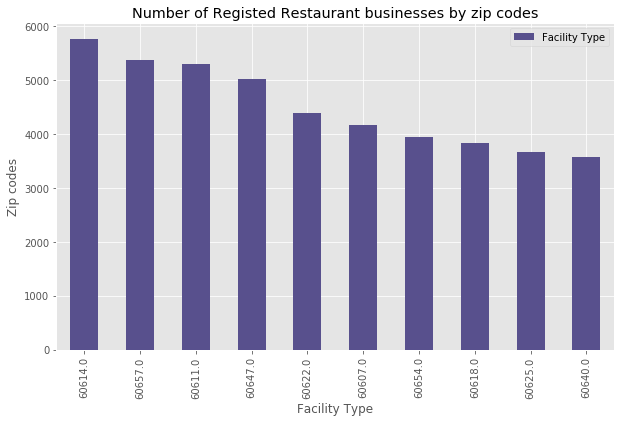

In [19]:
business_data.sort_values(by='Facility Type',ascending=False).head(10).plot(kind='bar', figsize=(10, 6), color='#58508d')

plt.xlabel('Facility Type') # add to x-label to the plot
plt.ylabel('Zip codes') # add y-label to the plot

plt.title('Number of Registed Restaurant businesses by zip codes') # add title to the plot

plt.show()

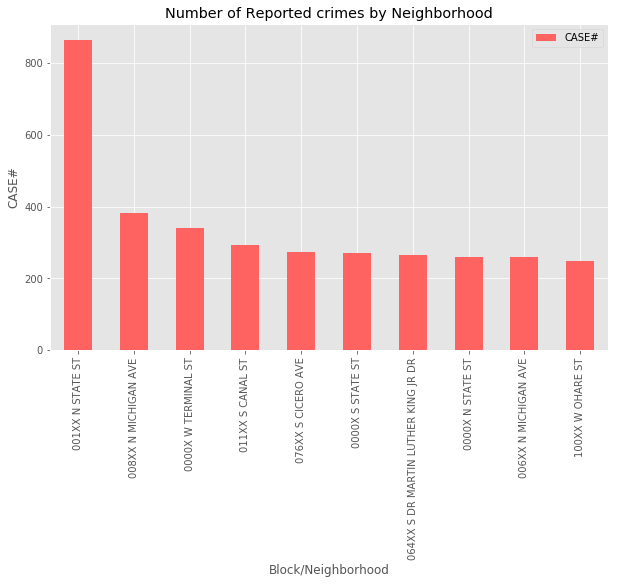

In [20]:
crime.sort_values(by='CASE#',ascending=False).head(10).plot(kind='bar', figsize=(10, 6), color='#ff6361')

plt.xlabel('Block/Neighborhood') # add to x-label to the plot
plt.ylabel('CASE#') # add y-label to the plot

plt.title('Number of Reported crimes by Neighborhood') # add title to the plot

plt.show()

### Merging the two restaurant and crime Data frames:
  - Only focusing on columns that we will need in future.

In [23]:
final_df = pd.concat([df[['DBA Name', 'Latitude', 'Longitude', 'Facility Type', 'Address', 'Zip']], df3[['CASE#', 'BLOCK']]], sort=False)
final_df.head()

,DBA Name,Latitude,Longitude,Facility Type,Address,Zip,CASE#,BLOCK
0,WOLFGANG PUCK CATERING & EVENTS AT SPERTUS INS...,41.874174,-87.624374,Restaurant,610 S MICHIGAN AVE,60605.0,NaN,NaN
1,HASHBROWNS,41.864682,-87.646288,Restaurant,731 W MAXWELL ST,60607.0,NaN,NaN
2,SUBWAY SANDWICHES,41.881994,-87.639759,Restaurant,500 W MADISON ST,60661.0,NaN,NaN
3,ARAMARK,41.881434,-87.630720,Restaurant,21 S CLARK ST,60603.0,NaN,NaN
4,EINSTEIN BROS. BAGELS #3561,41.940027,-87.653889,Restaurant,962 W BELMONT AVE,60657.0,NaN,NaN


In [24]:
merged_df = final_df.dropna(subset=['Longitude'])
merged_df = final_df.dropna(subset=['Latitude'])
merged_df = final_df.dropna(subset=['Zip'])
merged_df.head()

,DBA Name,Latitude,Longitude,Facility Type,Address,Zip,CASE#,BLOCK
0,WOLFGANG PUCK CATERING & EVENTS AT SPERTUS INS...,41.874174,-87.624374,Restaurant,610 S MICHIGAN AVE,60605.0,NaN,NaN
1,HASHBROWNS,41.864682,-87.646288,Restaurant,731 W MAXWELL ST,60607.0,NaN,NaN
2,SUBWAY SANDWICHES,41.881994,-87.639759,Restaurant,500 W MADISON ST,60661.0,NaN,NaN
3,ARAMARK,41.881434,-87.630720,Restaurant,21 S CLARK ST,60603.0,NaN,NaN
4,EINSTEIN BROS. BAGELS #3561,41.940027,-87.653889,Restaurant,962 W BELMONT AVE,60657.0,NaN,NaN


## Clustering Vegan Restaurants in Chicago neighborhoods:

* Getting all the rows from the data frame which contains Vegan in their DBA Name

In [25]:
vegan_rest = merged_df[merged_df['DBA Name'].str.contains('VEGAN',regex=False)]
vegan_rest

,DBA Name,Latitude,Longitude,Facility Type,Address,Zip,CASE#,BLOCK
2797,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Restaurant,1939-1943 W BYRON ST,60613.0,NaN,NaN
4609,URBAN VEGAN,41.961481,-87.669334,Restaurant,1601-1603 W MONTROSE AVE,60613.0,NaN,NaN
4672,URBAN VEGAN,41.961481,-87.669334,Restaurant,1601-1603 W MONTROSE AVE,60613.0,NaN,NaN
7218,URBAN VEGAN,41.961481,-87.669334,Restaurant,1601-1603 W MONTROSE AVE,60613.0,NaN,NaN
9025,GOOD FOODS VEGAN / VEGETARIAN,41.762619,-87.576682,Restaurant,1966 E 73RD ST,60649.0,NaN,NaN
16887,URBAN VEGAN,41.961478,-87.669492,Restaurant,1605 W MONTROSE AVE,60613.0,NaN,NaN
16926,URBAN VEGAN,41.961478,-87.669492,Restaurant,1605 W MONTROSE AVE,60613.0,NaN,NaN
17227,VEGAN PLATE,41.925266,-87.667793,Restaurant,1550 W FULLERTON AVE,60614.0,NaN,NaN
18955,TIWALADE VEGAN FOODS,41.779863,-87.644528,Restaurant,740 W 63RD ST,60621.0,NaN,NaN
23949,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Restaurant,1939-1943 W BYRON ST,60613.0,NaN,NaN


## 4. Visualizing the Data

In [26]:
# Find the center of all the locations and prepare the folium map
center_lat=merged_df.Latitude.mean()
center_long=merged_df.Longitude.mean()

map_chicago = folium.Map(location=[center_lat, center_long], zoom_start=11)   # generate map 
for lat,lng,name,address in zip(vegan_rest['Latitude'],vegan_rest['Longitude'],vegan_rest['DBA Name'],vegan_rest['Address']):
    label = '{}, {}'.format(address, name)
    label = folium.Popup(str(label), parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius= 5,
    color= 'blue',
    popup=label,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6).add_to(map_chicago)

map_chicago

In [27]:
# save the map as HTML file
map_chicago.save('map_chicago.html')

### Using KMeans clustering

In [28]:
# set number of clusters
kclusters = 8

chicago_clustering = vegan_rest.drop(['DBA Name','Facility Type','Address', 'Zip', 'CASE#', 'BLOCK'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
vegan_rest.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
vegan_rest.head()

,Cluster Labels,DBA Name,Latitude,Longitude,Facility Type,Address,Zip,CASE#,BLOCK
2797,5,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Restaurant,1939-1943 W BYRON ST,60613.0,NaN,NaN
4609,2,URBAN VEGAN,41.961481,-87.669334,Restaurant,1601-1603 W MONTROSE AVE,60613.0,NaN,NaN
4672,2,URBAN VEGAN,41.961481,-87.669334,Restaurant,1601-1603 W MONTROSE AVE,60613.0,NaN,NaN
7218,2,URBAN VEGAN,41.961481,-87.669334,Restaurant,1601-1603 W MONTROSE AVE,60613.0,NaN,NaN
9025,1,GOOD FOODS VEGAN / VEGETARIAN,41.762619,-87.576682,Restaurant,1966 E 73RD ST,60649.0,NaN,NaN


In [35]:
center_lat=merged_df.Latitude.mean()
center_long=merged_df.Longitude.mean()

# create map
map_clusters = folium.Map(location=[center_lat, center_long], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, address, cluster in zip(vegan_rest['Latitude'], vegan_rest['Longitude'], vegan_rest['DBA Name'], vegan_rest['Address'], vegan_rest['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.2).add_to(map_clusters)
       
map_clusters

In [36]:
# save the map as HTML file
map_clusters.save('map_chicago.html')

## 5. Foursquare Data Analysis
   * Foursquare API will allow us to retrieve information about the most popular spots in each neighborhood in         Chicago and its neighborhoods

#### Define Foursquare Credentials and Version

In [39]:
CLIENT_ID = 'ZJ4B5QNLUEXR4MDOZMDYFHXTYXHGYVHNHYRMXT3KRK5VHLBR' # your Foursquare ID
CLIENT_SECRET = 'TCBRAIV1BN1B2L5LA52W2IGHZ4W0AITQZT3O0CAWI5N34NTT' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZJ4B5QNLUEXR4MDOZMDYFHXTYXHGYVHNHYRMXT3KRK5VHLBR
CLIENT_SECRET:TCBRAIV1BN1B2L5LA52W2IGHZ4W0AITQZT3O0CAWI5N34NTT


In [40]:
#Let's use a function to get list of venues within 500 m from each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
vegan_venues = getNearbyVenues(names=vegan_rest['DBA Name'],
                                   latitudes=vegan_rest['Latitude'],
                                   longitudes=vegan_rest['Longitude']
                                  )


THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
URBAN VEGAN
URBAN VEGAN
URBAN VEGAN
GOOD FOODS VEGAN / VEGETARIAN
URBAN VEGAN
URBAN VEGAN
VEGAN PLATE
TIWALADE VEGAN FOODS
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
VEGAN PLATE
URBAN VEGAN
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
VEGAN NOW INC
URBAN VEGAN
URBAN VEGAN
VEGAN PLATE
URBAN VEGAN
VEGAN PLATE
URBAN VEGAN
URBAN VEGAN
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
VEGAN PLATE
THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA
URBAN VEGAN
VEGAN NOW INC
URBAN VEGAN
VEGAN NOW INC
VEGAN PLATE
VEGAN PLATE
GOOD FOODS VEGAN / VEGETARIAN
URBAN VEGAN
VEGAN NOW INC
VEGAN PLATE
GOOD FOODS VEGAN / VEGETARIAN
URBAN VEGAN
URBAN VEGAN
URBAN VEGAN
VEGAN PLATE
GOOD FOODS VEGAN / VEGETARIAN
URBAN VEGAN
VEGAN PLATE
GOOD FOODS VEGAN / VEGETARIAN
URBAN VEGAN
GOOD FOODS VEGAN / VEGETARIAN
GOOD FOODS VEGAN / VEGETARIAN
VEGAN PLATE
URBAN VEGAN
URBAN VEGAN


In [42]:
print(vegan_venues.shape)
vegan_venues.head()

(1513, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Big Bricks,41.951417,-87.676863,Pizza Place
1,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Orange Garden Restaurant,41.954209,-87.678169,Chinese Restaurant
2,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Wasabi Cafe Sushi & Sake,41.952650,-87.677794,Sushi Restaurant
3,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Dance Center Chicago,41.952276,-87.677685,Dance Studio
4,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,41.952238,-87.677804,Trader Joe's,41.949938,-87.675500,Grocery Store


### Let's see a graphic representation of the most popular venue categories across the neighborhoods:

In [44]:
venue_col = vegan_venues[['Venue Category', 'Venue']]
venue_col.head()

,Venue Category,Venue
0,Pizza Place,Big Bricks
1,Chinese Restaurant,Orange Garden Restaurant
2,Sushi Restaurant,Wasabi Cafe Sushi & Sake
3,Dance Studio,Dance Center Chicago
4,Grocery Store,Trader Joe's


In [45]:
venue_items = venue_col.groupby('Venue Category').count()
venue_items.sort_values(["Venue"], axis=0, ascending=False, inplace=True) 
venue_items.head()

,Venue
Venue Category,
Pizza Place,82
Sandwich Place,65
Mexican Restaurant,58
Bar,45
Seafood Restaurant,43


#### The graph below counts  most frequently occurring popular venue types in the prioritized neighborhoods, sorted from most frequent to least. It seems like pizza places are most popular venue type:

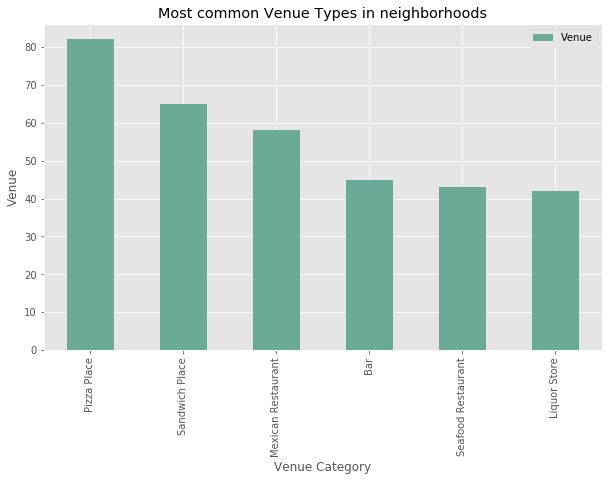

In [46]:
venue_items.sort_values(by='Venue',ascending=False).head(6).plot(kind='bar', figsize=(10, 6), color='#6aaa96')

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Venue') # add y-label to the plot

plt.title('Most common Venue Types in neighborhoods') # add title to the plot

plt.show()

#### Now, we'll go in depth of each neighborhood to see the most popular types of venues for each neighborhoods

### Creating a data frame of venue categories with pandas one hot encoding

In [68]:
# one hot encoding 
chicago_onehot = pd.get_dummies(vegan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = vegan_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

# To view the first five elements of the dataframe
chicago_onehot.head()

,Neighborhood,ATM,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Garden,Beer Store,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Café,Chinese Restaurant,Chiropractor,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Convenience Store,Cosmetics Shop,Currency Exchange,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,German Restaurant,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Liquor Store,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Music Venue,New American Restaurant,Non-Profit,Opera House,Park,Peruvian Restaurant,Pharmacy,Pie Shop,Pizza Place,Poke Place,Pub,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tea Room,Theater,Thrift / Vintage Store,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,URBAN VEGAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,URBAN VEGAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,URBAN VEGAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,URBAN VEGAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,URBAN VEGAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Using pandas groupby to get the mean of the one-hot encoded venue categories

In [69]:
# Grouping the data
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
print(chicago_grouped.shape)
chicago_grouped

(6, 99)


,Neighborhood,ATM,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Garden,Beer Store,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Café,Chinese Restaurant,Chiropractor,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Convenience Store,Cosmetics Shop,Currency Exchange,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,German Restaurant,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Liquor Store,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Moving Target,Music Venue,New American Restaurant,Non-Profit,Opera House,Park,Peruvian Restaurant,Pharmacy,Pie Shop,Pizza Place,Poke Place,Pub,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tea Room,Theater,Thrift / Vintage Store,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,GOOD FOODS VEGAN / VEGETARIAN,0.000000,0.074074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.00,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.074074,0.037037,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.074074,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.00
1,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.016667,0.000000,0.05,0.016667,0.016667,0.000000,0.033333,0.016667,0.016667,0.016667,0.000000,0.000000,0.016667,0.016667,0.033333,0.000000,0.016667,0.050000,0.016667,0.000000,0.000000,0.000000,0.000000,0.016667,0.033333,0.000000,0.033333,0.066667,0.000000,0.016667,0.033333,0.000000,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.016667,0.016667,0.016667,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.016667,0.000000,0.016667,0.016667,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.016667,0.016667,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.05
2,TIWALADE VEGAN FOODS,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.09

### Transposing the data frame and arrange it in descending order

In [91]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create the new dataframe and display the top 10 venues for each neighborhood to get better idea

In [89]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,GOOD FOODS VEGAN / VEGETARIAN,ATM,Opera House,Non-Profit,Music Venue,Moving Target,Movie Theater,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Massage Studio
1,THE CHICAGO HOUSE OF 'ZA VEGAN PIZZERIA,ATM,Dessert Shop,Restaurant,Record Shop,Donut Shop,Poke Place,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,Gourmet Shop
2,TIWALADE VEGAN FOODS,Ice Cream Shop,Park,Opera House,Non-Profit,New American Restaurant,Music Venue,Moving Target,Movie Theater,Mobile Phone Shop,Middle Eastern Restaurant
3,URBAN VEGAN,ATM,Music Venue,Moving Target,Movie Theater,Mobile Phone Shop,Middle Eastern Restaurant,Massage Studio,Market,New American Restaurant,Latin American Restaurant
4,VEGAN NOW INC,ATM,Park,Non-Profit,Music Venue,Moving Target,Movie Theater,Mobile Phone Shop,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant


## Conclusion : 
    This data is important because it gives us an idea of the atmosphere of each neighborhoods. As someone trying to open a vegan restaurant, I might want to know whether my location is already a hot spot for other bars and restaurants. It looks like most common venue for these vegan restaurants are ATMs, Opera House, Music Venue. So, if someone wants to open a vegan restaurant in Chicago or its  neighborhood, they should consider opening it by Movie Theater or Market. Having resturant by movie theater and marker would be a good deal because you know that people always go to these places and would love to hangout or have lunch or dinner after movie or after going to market. 